In [ ]:
import pandas as pd
import numpy as np
import missingno as msno
from yellowbrick.features import ParallelCoordinates
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import os
import math
import seaborn as sns
from numpy import array

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
##import data
sepsis_df = pd.read_csv('Sepsis-Raw-Data-A.csv')

##Feature Selection
#Drop Source, patient and EtCO2 columns
X = sepsis[sepsis.columns[2:42]] #features
X = X.drop(columns=['EtCO2'])
y = sepsis['SepsisLabel']  #target

pd.DataFrame(X).describe()

#Impute mean for null values
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X)
X_imp = pd.DataFrame(imp.transform(X))
X_imp.columns = X.columns #maintain feature names
pd.DataFrame(X_imp).describe()

#Feature Selection Technique 1
from sklearn.feature_selection import mutual_info_classif
importance = mutual_info_classif(X_imp,y)
feat_importances = pd.Series(importance, X.columns[0:len(X)])
feat_importances.plot(kind='barh')
plt.show()

pd.DataFrame(feat_importances).sort_values(by=[0], ascending=False)

#Technique 2: Correlation Coefficient
import seaborn as sns
cor=sepsis.corr()

plt.figure(figsize = (30, 25))
sns.heatmap(cor, annot=True)
#Sort values by feature importance
cor.sort_values(by=['SepsisLabel'], ascending=False)

#Technique 3: Select K Best using f_classif (based on ANOVA F-value)
from sklearn.feature_selection import f_classif
fs = SelectKBest(score_func=f_classif, k=10)
fs.fit_transform(X_imp, y)

cols = fs.get_support(indices=True)  #maintain feature names
X_selected = X_imp.iloc[:,cols]

pd.DataFrame(X_selected)

#Print all scores & sort. 
feat_names = list(X_imp.columns.values)
print(feat_names)
pd.DataFrame({'Feature':feat_names, 'Score':fs.scores_}, columns = ['Feature', 'Score']).sort_values(by=['Score'], ascending=False) 

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())
print(tf.test.is_built_with_gpu_support())

Found GPU at: /device:GPU:0
Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True
True


In [ ]:
pd.set_option('display.max_columns', None)
sepsis_copy = sepsis_df.copy()
sepsis_copy.head(10)

,Source,patient,ICULOS,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,SepsisLabel
0,A,p000001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,0
1,A,p000001,2,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,0
2,A,p000001,3,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,0
3,A,p000001,4,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,NaN,NaN,7.36,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,0
4,A,p000001,5,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,NaN,0.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,0
5,A,p000001,6,110.0,91.0,NaN,NaN,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,0
6,A,p000001,7,108.0,92.0,36.11,123.0,77.00,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,0
7,A,p000001,8,106.0,90.5,NaN,93.0,76.33,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,0
8,A,p000001,9,104.0,95.0,NaN,133.0,88.33,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,0
9,A,p000001,10,102.0,91.0,NaN,134.0,87.33,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,0


In [ ]:
##number of unique patients
sepsis_copy.patient.nunique()

20336

In [ ]:
selected_features=['ICULOS','patient','HR', 'Temp','Resp', 'Creatinine','Gender','HospAdmTime','SepsisLabel']
sepsis_df.drop(sepsis_df.columns.difference(selected_features), axis=1, inplace=True)
pd.set_option('display.max_rows', None)
sepsis_df.head(2)

,patient,ICULOS,HR,Temp,Resp,Creatinine,Gender,HospAdmTime,SepsisLabel
0,p000001,1,NaN,NaN,NaN,NaN,0,-0.03,0
1,p000001,2,97.0,NaN,19.0,NaN,0,-0.03,0


In [ ]:
# create patient with sepsis df
sepsis_dx = sepsis_df.loc[sepsis_df['SepsisLabel'] == 1]
patients_sep_dx = pd.DataFrame(sepsis_dx.patient.unique())
list_of_patients = patients_sep_dx[0].to_list()
sepsis_dx.tail()

,patient,ICULOS,HR,Temp,Resp,Creatinine,Gender,HospAdmTime,SepsisLabel
790210,p020643,31,88.0,NaN,16.0,NaN,1,-0.03,1
790211,p020643,32,96.0,38.72,16.0,2.5,1,-0.03,1
790212,p020643,33,140.0,NaN,16.0,NaN,1,-0.03,1
790213,p020643,34,120.0,NaN,16.0,NaN,1,-0.03,1
790214,p020643,35,115.0,NaN,16.0,NaN,1,-0.03,1


In [ ]:
# create non sepsis patients dx
no_dx_patients = sepsis_df[~sepsis_df['patient'].isin(sepsis_dx['patient'])]
no_dx_patients['dx'] = no_dx_patients['dx']=0
no_dx_patients.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,patient,ICULOS,HR,Temp,Resp,Creatinine,Gender,HospAdmTime,SepsisLabel,dx
0,p000001,1,NaN,NaN,NaN,NaN,0,-0.03,0,0
1,p000001,2,97.0,NaN,19.0,NaN,0,-0.03,0,0
2,p000001,3,89.0,NaN,22.0,NaN,0,-0.03,0,0
3,p000001,4,90.0,NaN,30.0,NaN,0,-0.03,0,0
4,p000001,5,103.0,NaN,24.5,NaN,0,-0.03,0,0
5,p000001,6,110.0,NaN,22.0,NaN,0,-0.03,0,0
6,p000001,7,108.0,36.11,29.0,NaN,0,-0.03,0,0
7,p000001,8,106.0,NaN,29.0,NaN,0,-0.03,0,0
8,p000001,9,104.0,NaN,26.0,NaN,0,-0.03,0,0
9,p000001,10,102.0,NaN,30.0,NaN,0,-0.03,0,0


In [ ]:
# join datasets together
dx_patients_df = sepsis_df[sepsis_df['patient'].isin(sepsis_dx['patient'])].copy()
dx_patients_df['dx'] = dx_patients_df['dx']=1
dx_patients_df.head(10)

,patient,ICULOS,HR,Temp,Resp,Creatinine,Gender,HospAdmTime,SepsisLabel,dx
304,p000009,1,NaN,NaN,NaN,NaN,1,-0.03,0,1
305,p000009,2,117.0,NaN,20.0,NaN,1,-0.03,0,1
306,p000009,3,NaN,NaN,NaN,NaN,1,-0.03,0,1
307,p000009,4,NaN,NaN,NaN,NaN,1,-0.03,0,1
308,p000009,5,NaN,NaN,NaN,NaN,1,-0.03,0,1
309,p000009,6,NaN,NaN,NaN,NaN,1,-0.03,0,1
310,p000009,7,120.0,36.00,30.0,1.0,1,-0.03,0,1
311,p000009,8,109.5,NaN,27.0,NaN,1,-0.03,0,1
312,p000009,9,102.5,35.67,24.5,NaN,1,-0.03,0,1
313,p000009,10,98.0,35.33,30.0,NaN,1,-0.03,0,1


In [ ]:
lstm_sepsis_df = no_dx_patients.append(dx_patients_df)

In [ ]:
## time series range
lstm_sepsis_df = lstm_sepsis_df.loc[(lstm_sepsis_df['ICULOS'] > 1)& (lstm_sepsis_df['ICULOS'] < 3)]

In [ ]:
lstm_sepsis_df.describe()

,ICULOS,HR,Temp,Resp,Creatinine,Gender,HospAdmTime,SepsisLabel,dx
count,16227.0,15810.000000,6240.000000,15433.000000,2478.000000,16227.000000,16226.000000,16227.000000,16227.000000
mean,2.0,85.308574,36.494115,17.989811,1.306881,0.563998,-50.600885,0.013126,0.092315
std,0.0,18.417631,0.948393,5.382951,1.541963,0.495903,149.985821,0.113819,0.289479
min,2.0,30.000000,26.670000,1.000000,0.100000,0.000000,-3322.900000,0.000000,0.000000
25%,2.0,72.000000,35.940000,14.000000,0.700000,0.000000,-30.557500,0.000000,0.000000
50%,2.0,84.000000,36.500000,17.000000,0.900000,1.000000,-1.830000,0.000000,0.000000
75%,2.0,96.500000,37.060000,21.000000,1.200000,1.000000,-0.020000,0.000000,0.000000
max,2.0,167.500000,41.110000,69.000000,21.400000,1.000000,23.990000,1.000000,1.000000


In [ ]:
selected_list=['HR', 'Temp','Resp', 'Creatinine','Gender','HospAdmTime']
input_data = []
labels = []
imp = SimpleImputer(missing_values=np.nan, strategy='median') #imput median for NaN values
imp.fit(lstm_sepsis_df[selected_list])
g = lstm_sepsis_df.groupby(by="patient")#create an timeseries array for each pt
for groupname, data in g:
  X_imp = imp.transform(data[selected_list])
  input_data.append(X_imp) #create list for input data
  labels.append(data.iloc[0]['dx'])#create list for dx label
  

In [ ]:
X, y = np.array(input_data) , np.array(labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=45)

In [ ]:
print(len(X_train))
print(len(X_test))
X_train

12170
4057


array([[[ 6.750e+01,  3.650e+01,  1.800e+01,  8.000e-01,  1.000e+00,
         -2.156e+01]],

       [[ 9.400e+01,  3.650e+01,  3.200e+01,  9.000e-01,  1.000e+00,
         -3.000e-02]],

       [[ 8.600e+01,  3.650e+01,  1.500e+01,  9.000e-01,  1.000e+00,
         -3.000e-02]],

       ...,

       [[ 9.800e+01,  3.711e+01,  1.300e+01,  9.000e-01,  1.000e+00,
         -6.730e+00]],

       [[ 8.600e+01,  3.650e+01,  2.100e+01,  9.000e-01,  1.000e+00,
         -7.636e+01]],

       [[ 5.950e+01,  3.661e+01,  1.000e+01,  9.000e-01,  1.000e+00,
         -9.470e+01]]])

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(1,6), return_sequences = True))
model.add(LSTM(128))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=3, batch_size=32, verbose=1, validation_split=0.2, shuffle=True)

Epoch 1/3
305/305 [==============================] - 5s 7ms/step - loss: 0.1041 - accuracy: 0.8862 - val_loss: 0.0840 - val_accuracy: 0.9076
Epoch 2/3
305/305 [==============================] - 2s 5ms/step - loss: 0.0847 - accuracy: 0.9058 - val_loss: 0.0839 - val_accuracy: 0.9076
Epoch 3/3
305/305 [==============================] - 1s 5ms/step - loss: 0.0828 - accuracy: 0.9081 - val_loss: 0.0831 - val_accuracy: 0.9076


In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes,average='weighted', labels=np.unique(yhat_classes))
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes, average='weighted', labels=np.unique(yhat_classes))
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes, average='weighted', labels=np.unique(yhat_classes))
print('F1 score: %f' % f1)

Accuracy: 0.910279
Precision: 0.910279
Recall: 1.000000
F1 score: 0.953032


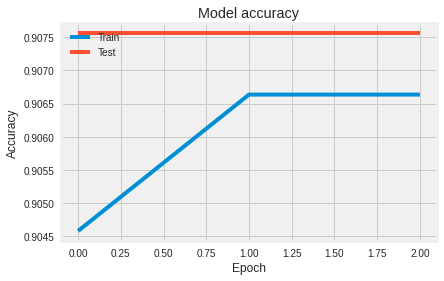

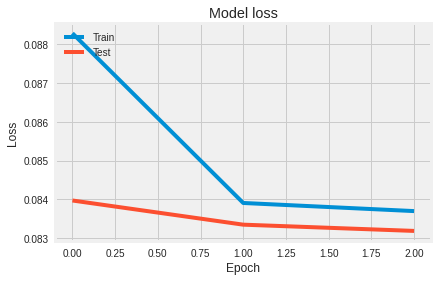

In [ ]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

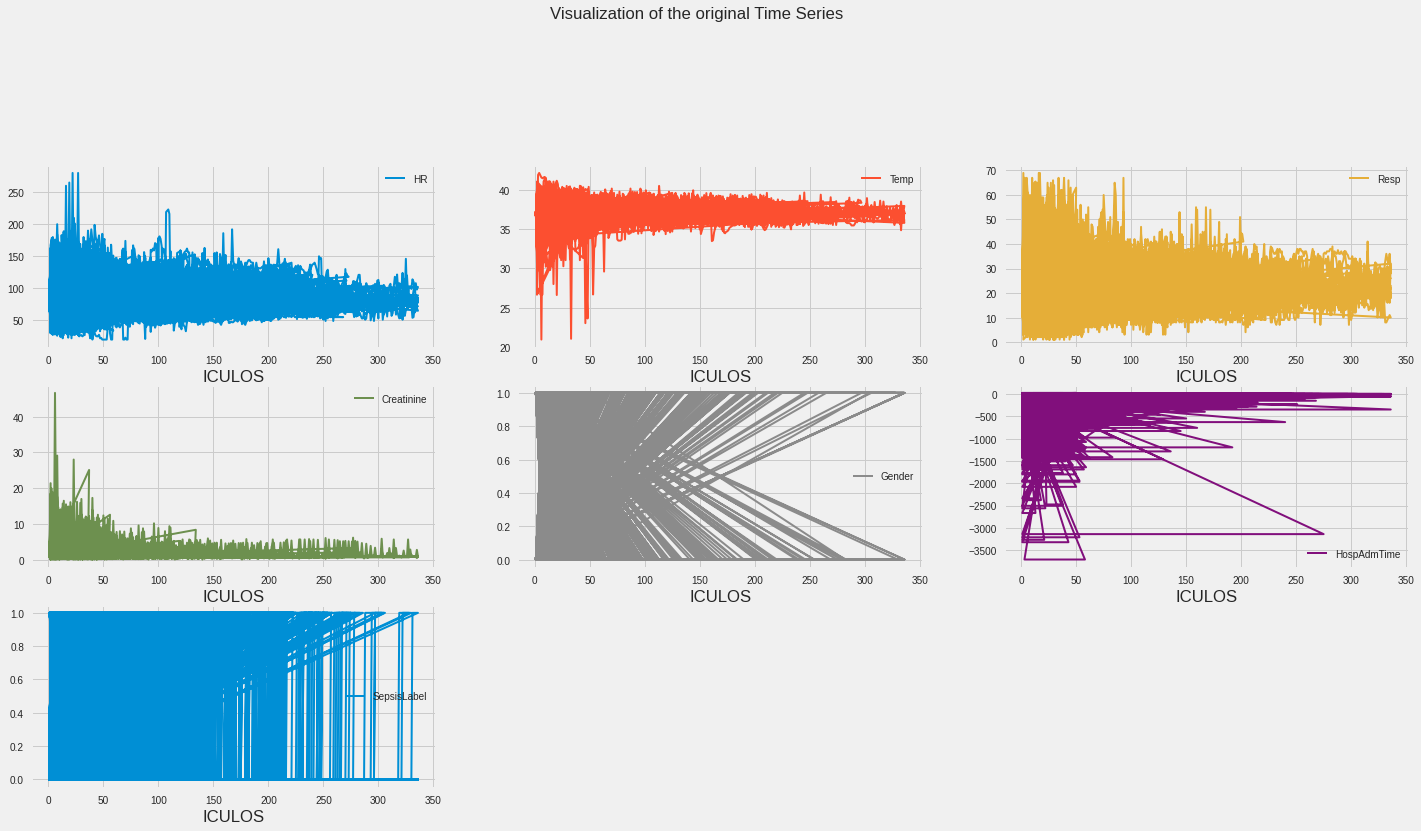

In [ ]:
plt.style.use('fivethirtyeight')
training.plot(subplots=True,
        layout=(6, 3),
        figsize=(22,22),
        fontsize=10, 
        linewidth=2,
        sharex=False,
        title='Visualization of the original Time Series')
plt.show()

In [ ]:
input_data_training

[]